# Classwise - Gridsearch

This notebook discusses Multi-label classification using gridsearch for the [academia.stackexchange.com](https://academia.stackexchange.com/).

A classifier is trained for each label individually. The best parameter is obtained for each classifier using *Gridsearch*.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Training](#training)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_X_reduced, get_y, get_test_train_data
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition

def get_X():
    return np.vstack([document.text for document in documents])
y = get_y()

X_train, X_test, y_train, y_test = get_test_train_data(get_X(), y, scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

preprocessing = PreprocessingDefinition('tfidf', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = get_test_train_data(get_X_reduced(preprocessing), y)

preprocessing = PreprocessingDefinition('count', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_count, X_test_count, y_train_count, y_test_count = get_test_train_data(get_X_reduced(preprocessing), y)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import word2vec, doc2vec, fasttext2vec

In [4]:
def get_data(embedding):
    if embedding == 'word2vec':
        X_train_, X_test_ = word2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'doc2vec':
        X_train_, X_test_ = doc2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'fasttext':
        X_train_, X_test_ = fasttext2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'tfidf':
        return X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf
    elif embedding == 'count':
        return X_train_count, X_test_count, y_train_count, y_test_count
    

In [5]:
paths = available_classifier_paths('classwise')
def create_classifier(classifier_options, name, embedding):
    path = [path for path in paths if name in path.name and embedding in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        preprocessing = PreprocessingDefinition(embedding, 'basic', 'basic', 'english', '1,1', 'None')
        classifier = ClasswiseClassifier(classifier_options, embedding)
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_, y_train_, y_test_ = get_data(embedding)
        clf.fit(X_train_, y_train_)
        clf.score(X_test_, y_test_)
        clf.save('classwise')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='training'/>

## Training

The [Classwise Classifier](../classwise_classifier.py) is trained for three different classification methods and their specific tuning parameter is found using [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV).
- Linear SVC, optimizing parameter `C`
- Logistic Regression, optimizing parameter `C`
- MLPClassifier, optimizing parameter `alpha`

[Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall#sklearn.metrics.recall_score) is used as  the scoring-function for the optimization. For reasons of that decision see [notebook 3.0](3.0-me-evaluation-metrics.ipynb).

In [6]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

**Word2Vec**

In [7]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearched', 'word2vec')

Training: 1289.8179833889008s
Test: 2.3447272777557373s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011925157512887419     0.07593712212817412      0.370161225312374        0.204552599758162        0.24659977735552102      
micro                                                            0.6920816044260027       0.1909828244274809       0.2993568650912354       
macro                                                            0.3251513302229493       0.0894738553274317       0.12546240362604003      


In [8]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearched', 'word2vec')

Training: 570.0486330986023s
Test: 2.1567602157592773s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011934703748488512     0.07762998790810158      0.3926723095525998       0.2290548166062072       0.26954060382718187      
micro                                                            0.6602294177435748       0.21693702290076336      0.32657018709376234      
macro                                                            0.3880069917548338       0.10136201970935416      0.14418907804804174      


In [9]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001, 0.001, 0.01, 0.1]})]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearched', 'word2vec')

**Doc2Vec**

In [10]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearched', 'doc2vec')

Training: 9038.803836107254s
Test: 3.1820929050445557s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012853688029020557     0.05211608222490931      0.21151753325272069      0.11178557033454253      0.1367578619150566       
micro                                                            0.5986552883372123       0.11044847328244274      0.18649051435936678      
macro                                                            0.24256468208517726      0.045419393964140076     0.06730405909469017      


In [11]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearched', 'doc2vec')

Training: 618.7757749557495s
Test: 3.4317002296447754s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01336091134729205      0.054171704957678354     0.26150966392199765      0.17309955663039095      0.18932968253581386      
micro                                                            0.4976648351648352       0.1728530534351145       0.256586402266289        
macro                                                            0.31068768135607555      0.10815678613656626      0.1489303985560861       


In [12]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001, 0.001, 0.01, 0.1]})]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearched', 'doc2vec')

**FastText**

In [13]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearched', 'fasttext')

Training: 1278.4993333816528s
Test: 2.0788393020629883s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01178005473175078      0.08162031438935913      0.3886537686416768       0.22074566706972998      0.2630978292163298       
micro                                                            0.6977720374556022       0.20620229007633586      0.3183324740369743       
macro                                                            0.38054000539135063      0.12465906137444453      0.1706587182986547       


In [14]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearched', 'fasttext')

Training: 640.4924702644348s
Test: 2.3410377502441406s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011837968561064087     0.08029020556227327      0.4038149939540508       0.2409552599758162       0.2807386614460375       
micro                                                            0.6644819411518617       0.22733778625954199      0.3387721730475276       
macro                                                            0.4356151818796932       0.12089241928680174      0.17303514757343064      


In [15]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001, 0.001, 0.01, 0.1]})]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearched', 'fasttext')

**TFIDF**

In [16]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearched', 'tfidf')

Training: 22990.471398353577s
Test: 17.889747858047485s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015740469674791573     0.036275695284159616     0.3771843630640487       0.3296251511487303       0.32157219107642326      
micro                                                            0.3897895826146947       0.32441743624096847      0.35411171754628784      
macro                                                            0.4600807432711681       0.23267665542189697      0.29158193578800107      


In [17]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearched', 'tfidf')

Training: 12269.40617966652s
Test: 16.42133617401123s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013763126073951505     0.05610640870616687      0.4018399838774688       0.29086054010479645      0.3108299701105021       
micro                                                            0.47123526153359185      0.2849418632470453       0.35514074427480913      
macro                                                            0.5140534630177787       0.17185162936236056      0.238425631256163        


In [18]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001, 0.001, 0.01, 0.1]})]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearched', 'tfidf')

**Count**

In [19]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearched', 'count')

Training: 31221.675328731537s
Test: 19.45798397064209s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.025701011900973715     0.020435308343409914     0.25413153287368534      0.32346634421604187      0.24947543098326416      
micro                                                            0.2047600255001366       0.32221850666411883      0.25039907933325906      
macro                                                            0.2678268533921631       0.22955931655186898      0.22639118851936277      


In [20]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearched', 'count')

Training: 13086.711846590042s
Test: 16.54396653175354s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.018592248456691912     0.03663845223700121      0.2919946827322885       0.2659834744054816       0.24874490680700226      
micro                                                            0.28673705897501933      0.2659437252185544       0.2759492415980966       
macro                                                            0.36297742094383495      0.15628508401314228      0.19907477911122473      


In [22]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001, 0.001, 0.01, 0.1]})]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearched', 'count')

<a id='evaluation'/>

## Evaluation

In [23]:
paths = available_classifier_paths('classwise')
paths = [path for path in paths if 'gridsearched' in path.name]

In [24]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf) + ' ' + str(clf.preprocessing.vectorizer), evaluation])

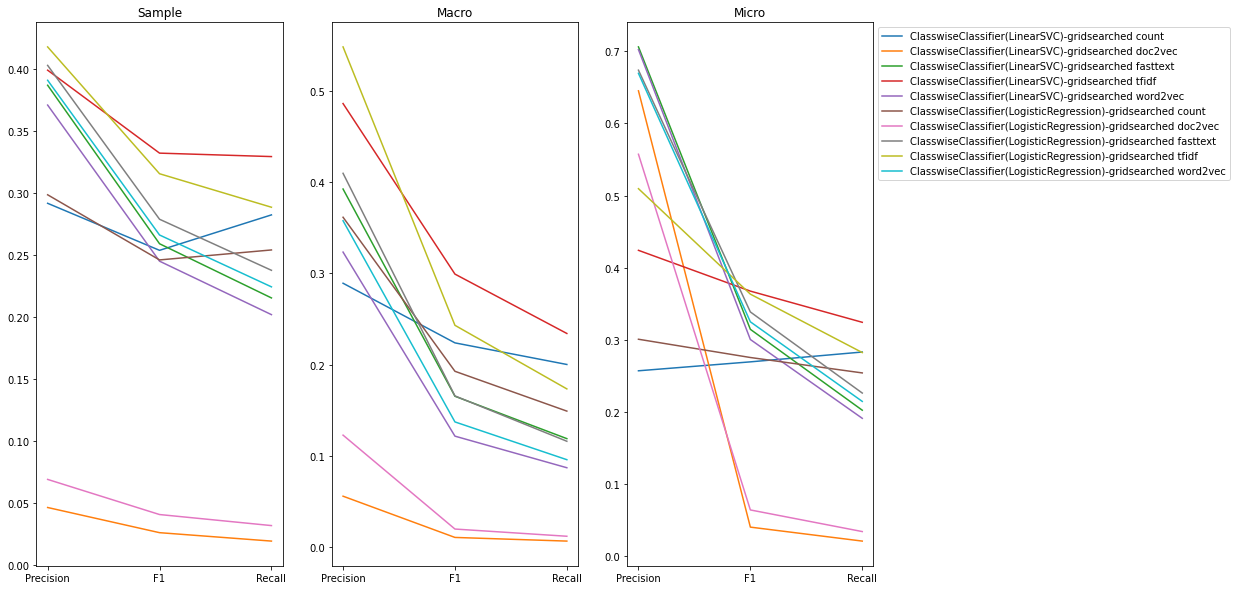

In [25]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [26]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [27]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [28]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    _, X_test_, _, y_test_ = get_data(clf.preprocessing.vectorizer)
    prediction = clf.predict(X_test_)
    label_accuracies = per_label_accuracy(y_test_, prediction)
    report = classification_report(y_test_, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((str(clf) + ' ' + str(clf.preprocessing.vectorizer), classwise_report))

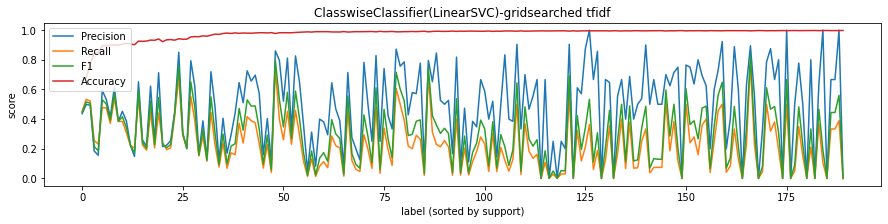

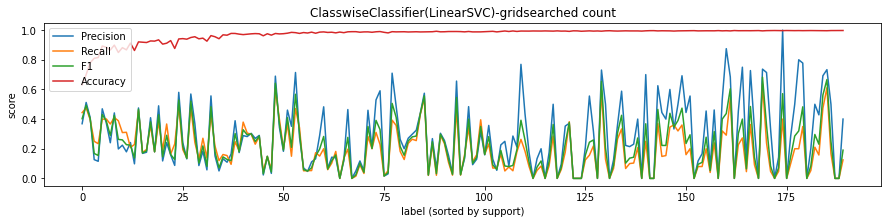

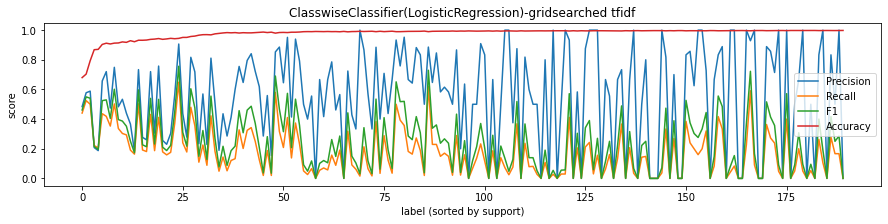

In [29]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()